In [ ]:
import pandas as pd

import backtester as bt

from abc import ABC, abstractmethod
import pandas as pd
from typing import List, Dict, Any
import numpy as np
from datetime import date, datetime


# initialize market

In [2]:
market = bt.MarketDataHandler()

universe = ['SPY US Equity', 'QQQ US Equity']
start_date='2005-01-1'
end_date='2025-06-10'
frequency = '1d'


In [ ]:
market.load_market(universe, start_date, end_date, rebuild=False)

# create a position

In [4]:
entry_mkt = market.market_data['2015-01-02']['EOD']
exit_mkt = market.market_data['2023-12-27']['EOD']

eq_position = bt.EquityPosition(symbol='SPY US Equity',
                                quantity=100,
                                market_data=entry_mkt,
                                position_type=bt.PositionType.LONG)

print("entry price: ", eq_position.entry_price)
print("ctv: ", eq_position.initial_ctv)
print("floating pnl: ", eq_position.calculate_pnl(exit_mkt))
print("closed_pnl: ", eq_position.closed_pnl)

entry price:  172.075
ctv:  17207.5
floating pnl:  29699.03
closed_pnl:  0


In [5]:
eq_position.close_position(exit_mkt)

print("entry price: ", eq_position.entry_price)
print("ctv: ", eq_position.initial_ctv)
print("floating pnl: ", eq_position.calculate_pnl(exit_mkt))
print("closed_pnl: ", eq_position.closed_pnl)

entry price:  172.075
ctv:  17207.5
floating pnl:  0
closed_pnl:  29699.03


# portfolio

il portafoglio ragiona by-trade

In [6]:
ptf = bt.Portfolio()
eq_position = bt.EquityPosition(symbol='SPY US Equity',
                                quantity=100,
                                market_data=entry_mkt,
                                position_type=bt.PositionType.LONG)
ptf.add_position(eq_position)

eq_position2 = bt.EquityPosition(symbol='SPY US Equity',
                                quantity=120,
                                market_data=entry_mkt,
                                position_type=bt.PositionType.LONG)
ptf.add_position(eq_position2)

eq_position3 = bt.EquityPosition(symbol='QQQ US Equity',
                                quantity=150,
                                market_data=entry_mkt,
                                position_type=bt.PositionType.SHORT)
ptf.add_position(eq_position3)

In [7]:
ptf.calculate_total_value(entry_mkt)

23608.735

In [8]:
eq_position.calculate_value(entry_mkt) * 100

17207.5

In [9]:
eq_position2.calculate_value(entry_mkt) * 120

20649.0

In [10]:
eq_position3.calculate_value(entry_mkt) * 150

14247.765000000001

In [11]:
-eq_position3.calculate_value(entry_mkt) * 150 + eq_position2.calculate_value(entry_mkt) * 120 + eq_position.calculate_value(entry_mkt) * 100

23608.735

In [12]:
summary = pd.DataFrame(ptf.get_positions_summary(entry_mkt))
summary

,ref_date,trade_date,trade_id,symbol,type,side,quantity,entry_price,is_alive,current_value,open_pnl,closed_pnl,global_pnl
0,2015-01-02,2015-01-02,40314,SPY US Equity,equity,1,100,172.0750,True,172.0750,0.0,0,0.0
1,2015-01-02,2015-01-02,23095,SPY US Equity,equity,1,120,172.0750,True,172.0750,0.0,0,0.0
2,2015-01-02,2015-01-02,53371,QQQ US Equity,equity,-1,150,94.9851,True,94.9851,-0.0,0,0.0


In [13]:
summary['global_pnl'].sum()

0.0

per ottenere tutte le posizioni di un underlying

In [14]:
spy_positions = ptf.get_positions(symbol='SPY US Equity', position_type=bt.AssetType.EQUITY)
spy_positions

refresh del portafoglio a una nuova data

In [15]:
mkt2 = market.market_data['2022-12-27']['EOD']

In [16]:
# print("initial ctv: ", ptf.get_initial_ctv())
print("total value: ", ptf.calculate_total_value(mkt2))
print("floating pnl: ", ptf.calculate_open_pnl(mkt2))
print("closed pnl: ", ptf.get_closed_pnl())

total value:  42384.670000000006
floating pnl:  18775.935000000005
closed pnl:  0


In [17]:
summary = pd.DataFrame(ptf.get_positions_summary(mkt2))
summary

,ref_date,trade_date,trade_id,symbol,type,side,quantity,entry_price,is_alive,current_value,open_pnl,closed_pnl,global_pnl
0,2022-12-27,2015-01-02,40314,SPY US Equity,equity,1,100,172.0750,True,369.8200,19774.500,0,19774.500
1,2022-12-27,2015-01-02,23095,SPY US Equity,equity,1,120,172.0750,True,369.8200,23729.400,0,23729.400
2,2022-12-27,2015-01-02,53371,QQQ US Equity,equity,-1,150,94.9851,True,259.8382,-24727.965,0,-24727.965


chiudi solo le posizioni di un ticker

In [18]:
ticker = 'SPY US Equity'

# positions = ptf.get_positions(symbol='SPY US Equity', position_type=bt.AssetType.EQUITY)
# for pos in positions:
#     pos.close_position(mkt2) 
ptf.close_positions(ticker, bt.AssetType.EQUITY, mkt2)

# print("initial ctv: ", ptf.get_initial_ctv())
print("total value: ", ptf.calculate_total_value(mkt2))
print("floating pnl: ", ptf.calculate_open_pnl(mkt2))
print("closed pnl: ", ptf.get_closed_pnl())

total value:  -38975.729999999996
floating pnl:  -24727.964999999997
closed pnl:  43503.9


 chiudi tutte le posizioni

In [19]:
ptf.close_all_positions(mkt2)

print("total value: ", ptf.calculate_total_value(mkt2))
print("floating pnl: ", ptf.calculate_open_pnl(mkt2))
print("closed pnl: ", ptf.get_closed_pnl())

total value:  0.0
floating pnl:  0
closed pnl:  18775.935000000005


# backtest buy and hold

In [20]:
class BenchmarkStrategy(bt.Backtester):
    def __init__(self, universe, start_date, end_date, starting_balance, max_leverage, frequency, rebuild):
        super().__init__(universe, start_date, end_date, starting_balance, max_leverage, frequency, rebuild)
        self.position_open = False

    def on_data(self):
        mkt = self.history[self.ref_date]
        if not self.position_open:
            size = int(self.balance[self.ref_date] / mkt['equity']['SPY US Equity']['close'])
            self.trade('SPY US Equity', quantity=size, market=mkt, assettype=bt.AssetType.EQUITY, side=bt.PositionType.LONG)
            self.position_open = True

class BuyHoldStrategy(bt.Backtester):
    def __init__(self, universe, start_date, end_date, starting_balance, max_leverage, frequency, rebuild):
        super().__init__(universe, start_date, end_date, starting_balance, max_leverage, frequency, rebuild)
        self.position_open = False

    def on_data(self):
        mkt = self.history[self.ref_date]
        try:
            size = int(self.balance[self.ref_dates[-2]] / mkt['equity']['SPY US Equity']['close'])
        except:
            size = int(self.starting_balance / mkt['equity']['SPY US Equity']['close'])
        if not self.position_open:
            self.trade('SPY US Equity', quantity=size, market=mkt, assettype=bt.AssetType.EQUITY, side=bt.PositionType.LONG)
            self.position_open = True

        if self.ref_date == "2023-12-27":
            self.portfolio.close_positions('SPY US Equity', bt.AssetType.EQUITY, mkt)

In [21]:
params = {"universe": ['SPY US Equity'],
          "start_date": '2022-01-01',
          "end_date": '2024-12-31',
          "starting_balance": 100000,
          'max_leverage': 4,
          'frequency': 'EOD',
          'rebuild': False}

benchmark = BenchmarkStrategy(**params)
benchmark.backtest()
res_benchmark = bt.Analytics(benchmark)

backtester = BuyHoldStrategy(**params)
backtester.backtest()
res = bt.Analytics(backtester)

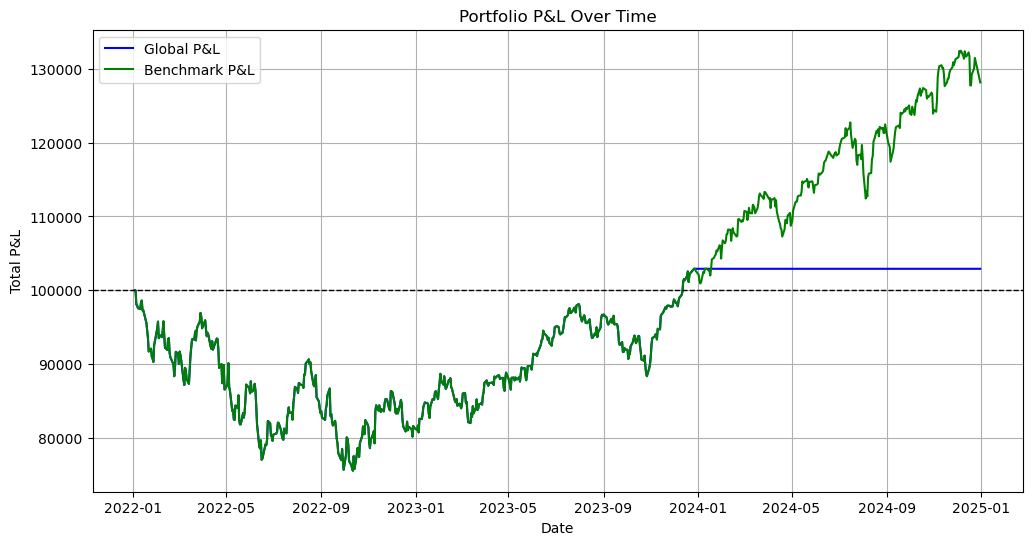

In [22]:
res.plot_pnl(benchmark=res_benchmark)

In [23]:
res.trade_log()

,ref_date,trade_date,trade_id,symbol,type,side,quantity,entry_price,is_alive,current_value,open_pnl,closed_pnl,global_pnl
0,2022-01-03,2022-01-03,90063,SPY US Equity,equity,1,219,455.8102,True,455.8102,0.0,0.0000,0.0000
1,2023-12-27,2022-01-03,90063,SPY US Equity,equity,1,0,455.8102,False,469.0653,0.0,2902.8669,2902.8669


# backtester Factor

In [ ]:

class MovingAverage(bt.Factor):
    def __init__(self, history, frequency, window, field = 'close'):
        super().__init__(history, frequency)
        self.window = window 
        self.field = field

    def compute(self):
        data = {}
        for date, market_data in self.history.items():
            market_data = market_data[self.frequency]
            equity_data = market_data.get('equity', {})
            for symbol, values in equity_data.items():
                if symbol not in data:
                    data[symbol] = {}
                data[symbol][date] = values.get(self.field, None)
        
        df = pd.DataFrame(data)
        df.index.name = "Date"
        return df.rolling(self.window).mean()

class Momentum(bt.Factor):
    def __init__(self, history: Dict[date, Any], frequency: str, window: int, field: str = 'close'):
        super().__init__(history, frequency)
        self.window = window
        self.field = field

    def compute(self) -> pd.DataFrame:
        """
        Calcola il momentum come differenza tra il prezzo di chiusura odierno
        e quello di `window` giorni fa, per ciascun simbolo.
        """
        data = {}
        for dt, mkt in self.history.items():
            mkt_freq = mkt[self.frequency]
            equity = mkt_freq.get('equity', {})
            for symbol, values in equity.items():
                data.setdefault(symbol, {})[dt] = values.get(self.field, None)

        df = pd.DataFrame(data)
        df.index.name = "Date"
        return df.diff(self.window)
    
class MaStrategy(bt.Backtester):
    def __init__(self, universe, start_date, end_date, starting_balance, max_leverage, frequency, rebuild):
        super().__init__(universe, start_date, end_date, starting_balance, max_leverage, frequency, rebuild)
        self.factors = [
                    MovingAverage(self.market.market_data, self.frequency, window=20, field='close'),
                    Momentum(self.market.market_data, self.frequency, window=20, field='close'),
                ]

    def on_data(self):
        mkt = self.history[self.ref_date]
        ma = self.factors_history['movingaverage']['SPY US Equity'].iloc[-1]
        try:
            prev_mkt = self.history[ self.ref_dates[-2]]
            prev_ma = self.factors_history['movingaverage']['SPY US Equity'].iloc[-2]
        except:
            return
        
        try:
            size = int(self.balance[self.ref_dates[-2]] / mkt['equity']['SPY US Equity']['close'])
        except:
            size = int(self.starting_balance / mkt['equity']['SPY US Equity']['close'])

        if mkt['equity']['SPY US Equity']['close'] > ma and prev_mkt['equity']['SPY US Equity']['close'] <= prev_ma:
            self.trade('SPY US Equity', quantity=size, market=mkt, assettype=bt.AssetType.EQUITY, side=bt.PositionType.LONG)

        if mkt['equity']['SPY US Equity']['close'] < ma and prev_mkt['equity']['SPY US Equity']['close'] >= prev_ma:
            self.portfolio.close_all_positions(mkt)
    

In [26]:
params = {"universe": ['SPY US Equity'],
          "start_date": '2022-01-01',
          "end_date": '2024-12-31',
          "starting_balance": 100000,
          'max_leverage': 4,
          'frequency': 'EOD',
          'rebuild': False}

backtester = MaStrategy(**params)
# self._on_start()
backtester.backtest()
res2 = bt.Analytics(backtester)

In [ ]:
res2.trade_log()

,ref_date,trade_date,trade_id,symbol,type,side,quantity,entry_price,is_alive,current_value,open_pnl,closed_pnl,global_pnl
0,2022-01-11,2022-01-11,55991,SPY US Equity,equity,1,2,448.2152,True,448.2152,0.0,0.0000,0.0000
1,2022-01-13,2022-01-11,55991,SPY US Equity,equity,1,0,448.2152,False,443.2345,0.0,-9.9614,-9.9614
2,2022-02-02,2022-02-02,15895,SPY US Equity,equity,1,2,436.3836,True,436.3836,0.0,0.0000,0.0000
3,2022-02-03,2022-02-02,15895,SPY US Equity,equity,1,0,436.3836,False,426.1264,0.0,-20.5144,-20.5144
4,2022-02-08,2022-02-08,55711,SPY US Equity,equity,1,2,430.2675,True,430.2675,0.0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2024-10-31,2024-09-12,25393,SPY US Equity,equity,1,0,553.8460,False,565.0337,0.0,22.3754,22.3754
70,2024-11-06,2024-11-06,84507,SPY US Equity,equity,1,1,587.2917,True,587.2917,0.0,0.0000,0.0000
71,2024-12-18,2024-11-06,84507,SPY US Equity,equity,1,0,587.2917,False,582.5618,0.0,-4.7299,-4.7299
72,2024-12-24,2024-12-24,66287,SPY US Equity,equity,1,1,599.4973,True,599.4973,0.0,0.0000,0.0000


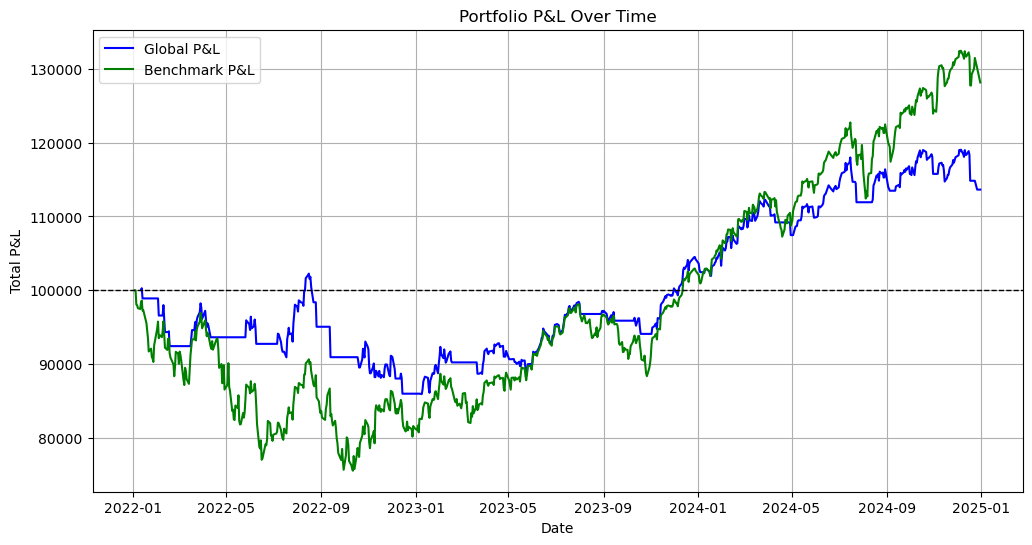

In [27]:
res2.plot_pnl(benchmark=res_benchmark)

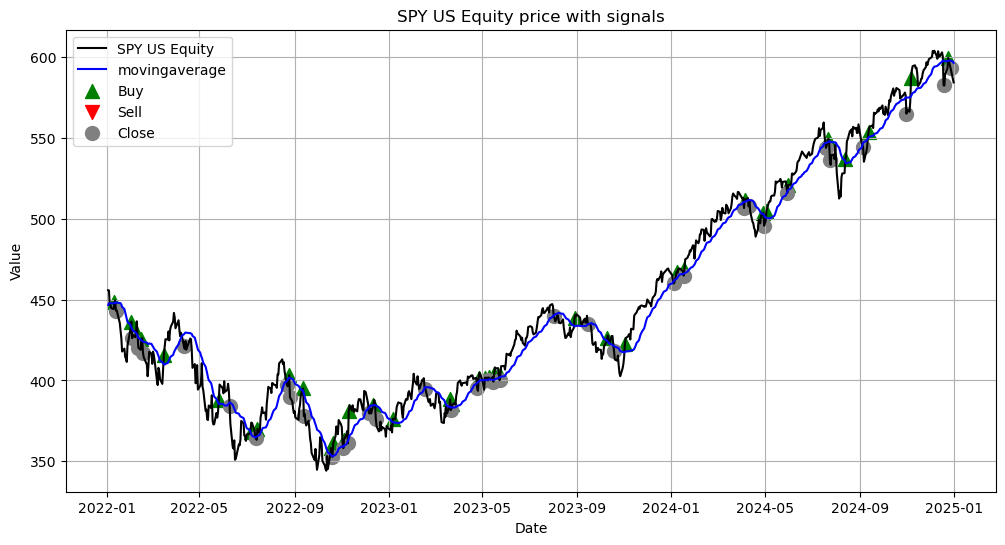

In [28]:
res2.plot_price('SPY US Equity', factor='movingaverage')

In [29]:
backtester.factors_df

factor     movingaverage                    momentum              
symbol     SPY US Equity QQQ US Equity SPY US Equity QQQ US Equity
Date                                                              
2005-01-03           NaN           NaN           NaN           NaN
2005-01-04           NaN           NaN           NaN           NaN
2005-01-05           NaN           NaN           NaN           NaN
2005-01-06           NaN           NaN           NaN           NaN
2005-01-07           NaN           NaN           NaN           NaN
...                  ...           ...           ...           ...
2025-06-10      591.4925      521.5830         20.09         26.36
2025-06-11      592.2185      522.4240         14.52         16.82
2025-06-12      593.0265      523.1730         16.16         14.98
2025-06-13      593.3535      523.5585          6.54          7.71
2025-06-16      593.7775      524.1975          8.48         12.78

[5146 rows x 4 columns]